In [1]:
import torch

/home/rd654/.cache/pypoetry/virtualenvs/pos-merge-Cf-JYAyy-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

In [5]:
import sys
sys.path.append('../')

In [6]:
from src.utils.data import DatasetPreprocessor

In [7]:
from src.utils.data import POSLookup

In [8]:
from src.tokenizer import load_tokenizer

In [16]:
# setting up hydra config 
from hydra import compose, initialize
from omegaconf import OmegaConf
from src.config import BabyLMConfig 

from hydra.core.config_store import ConfigStore

cs = ConfigStore.instance()
cs.store(name="base_config", node=BabyLMConfig)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config", overrides=[
        "experiment.group=dev", "experiment.name=test-1", "experiment.dry_run=True", "objective_curriculum=base_pos_merge",
        "dataset.subconfig=original_strict_small_gold",
        "pos_lookup.similarity_metric=js_divergence",
        ])


In [17]:
dataset = load_dataset(
    cfg.dataset.name,
    cfg.dataset.subconfig, 
)

Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 10.60it/s]
Generating train split: 1015485 examples [00:28, 35128.15 examples/s]
Generating validation split: 985958 examples [00:28, 35141.54 examples/s]
Generating test split: 1008786 examples [00:28, 35118.54 examples/s]


**Loading in the tokenizer and creating a mapping of token_id to token_str**

In [18]:
tokenizer = load_tokenizer(cfg)

In [19]:
vocab_tokenizer = tokenizer._tokenizer.get_vocab()
vocab_tokenizer__key_to_token = {v: k for k, v in vocab_tokenizer.items()}

**Setting up the train dataset and the POS Lookup matrix**

In [20]:
data_preprocessor = DatasetPreprocessor(cfg, tokenizer)

train_dataset = dataset["train"].map(
    data_preprocessor,
    batched=True,
    num_proc=64,
    remove_columns=dataset["train"].column_names,
)


Map (num_proc=64): 100%|██████████| 1015485/1015485 [00:22<00:00, 45132.87 examples/s]


In [21]:
pos_lookup = POSLookup(train_dataset, tokenizer, similarity_metric=cfg.pos_lookup.similarity_metric)

100%|██████████| 8102/8102 [00:00<00:00, 28925.47it/s]


Getting the sum across the 1st dimension in order to compute the total count of POS tags (total occurences of that subword).

In [22]:
lookup_matrix = pos_lookup.lookup_matrix
total_freq = lookup_matrix.sum(dim=1)

**Sorting indices by their frequencies and plotting**

In [23]:
sorted_pos_freq_indices = torch.argsort(total_freq, descending=True)

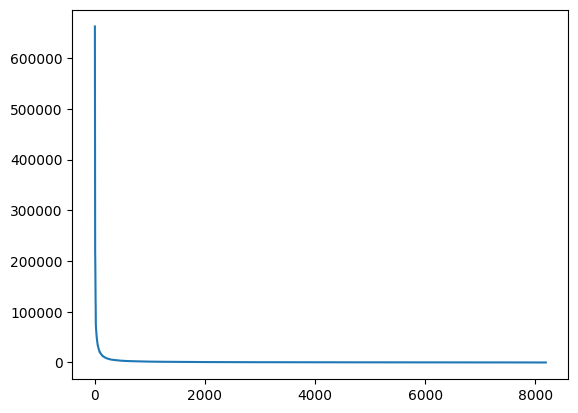

In [24]:
import matplotlib.pyplot as plt

plt.plot(total_freq[sorted_pos_freq_indices].numpy())

In [25]:
most_popular_tokens = sorted_pos_freq_indices[:5]
least_popular_tokens = sorted_pos_freq_indices[-5:]

print("POPULAR TOKENS")
print(10*"--")
for i in most_popular_tokens:
    print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
    print("Frequency: ", total_freq[i].item())

print(10*"--")
print("LEAST POPULAR TOKENS")
print(10*"--")
for i in least_popular_tokens:
    print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
    print("Frequency: ", total_freq[i].item())
print(10*"--")

# NOTE: We might also want to look at the distribution of POS tags in the dataset
# i.e. how to adjectives cluster, how do verbs cluster, etc.

POPULAR TOKENS
--------------------
18 --- ['.']
Frequency:  662549.0
16 --- [',']
Frequency:  536139.0
266 --- ['Ġthe']
Frequency:  482760.0
294 --- ['Ġand']
Frequency:  236186.0
284 --- ['Ġto']
Frequency:  227551.0
--------------------
LEAST POPULAR TOKENS
--------------------
61 --- ['Y']
Frequency:  0.0
60 --- ['X']
Frequency:  0.0
59 --- ['W']
Frequency:  0.0
58 --- ['V']
Frequency:  0.0
57 --- ['U']
Frequency:  0.0
--------------------


#### Plotting similarity among most and least popular tokens

In [26]:
similarity_vals_popular = pos_lookup.find_similar(most_popular_tokens)
similarity_vals_least_popular = pos_lookup.find_similar(least_popular_tokens)

In [27]:
def plot_vals(similarity_vals):
    for i, val in enumerate(similarity_vals):

        similarity_vals_sorted = val.tolist()
        similarity_vals_sorted.sort()
        plt.plot(similarity_vals_sorted)#, label=f"POS {val}")
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


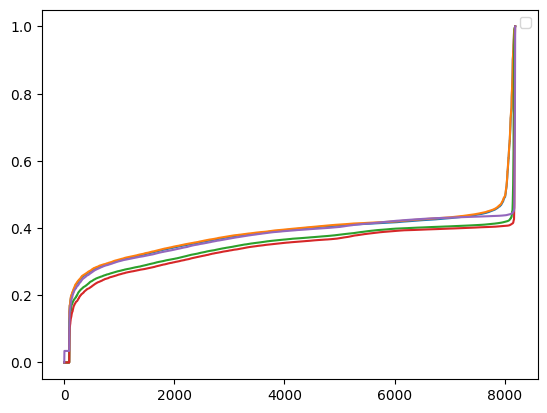

In [28]:
plot_vals(similarity_vals_popular)


In [29]:
similarity_vals_least_popular.shape

torch.Size([5, 8192])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


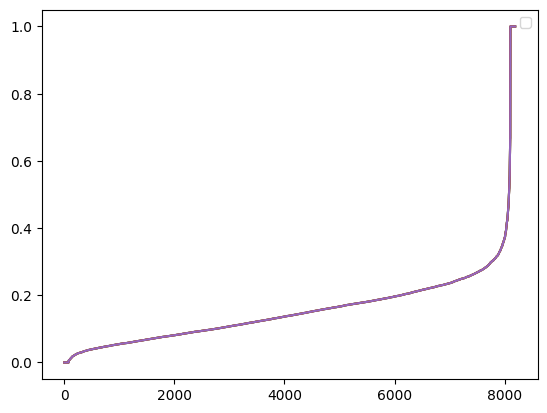

In [30]:
plot_vals(similarity_vals_least_popular)

### Grouping by type of POS TAG 

In [31]:
from src.utils.data import POS_TAG_MAP

In [32]:
normalized_lookup_matrix = lookup_matrix + 1e-8 
normalized_lookup_matrix = normalized_lookup_matrix / normalized_lookup_matrix.sum(dim=1).unsqueeze(1)

In [33]:
def get_representative_token_idx_for_pos(pos_tag, comparison_factor=0.7):
    """
    returns a tuple of 
        * the indices of tokens that are primarily of a given POS tag, as well as 
        * the same indices but sorted by their frequency (descending)
    """
    primarily_pos_mask = normalized_lookup_matrix[:, POS_TAG_MAP[pos_tag]] > comparison_factor
    primarily_pos_idx = primarily_pos_mask.nonzero(as_tuple=True)[0]

    primarily_pos_idx_sorted_indices = torch.argsort(total_freq[primarily_pos_idx], descending=True)
    primarily_pos_idx_sorted = primarily_pos_idx[primarily_pos_idx_sorted_indices]

    return primarily_pos_idx, primarily_pos_idx_sorted

In [34]:
def print_top_representative_tokens(primarily_pos_idx_sorted):
    for i in primarily_pos_idx_sorted[:5]:
        print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
        print("Frequency: ", total_freq[i].item())
        print("POS Distribution: ", normalized_lookup_matrix[i].numpy())
        print(10*"--")

In [35]:
def print_least_representative_tokens(primarily_pos_idx_sorted):
    for i in primarily_pos_idx_sorted[-5:]:
        print(i.item(), "---", tokenizer.convert_ids_to_tokens([i]))
        print("Frequency: ", total_freq[i].item())
        print("POS Distribution: ", normalized_lookup_matrix[i].numpy())
        print(10*"--")

In [36]:
representative_POS_tokens = { 
    tag: get_representative_token_idx_for_pos(tag) for tag in POS_TAG_MAP.keys() if tag not in ["X", "ADV"]
}

In [37]:
print("MOST REPRESENTATIVE TOKENS")
print(10*"--")
for tag in representative_POS_tokens.keys():
    print(tag)
    print(10*"--")
    print_top_representative_tokens(representative_POS_tokens[tag][1])
    print(10*"--")

MOST REPRESENTATIVE TOKENS
--------------------
NOUN
--------------------
87 --- ['s']
Frequency:  59055.0
POS Distribution:  [7.7688593e-01 1.2747438e-01 4.2401150e-02 7.2644143e-03 6.2822793e-03
 3.2342731e-03 4.1486751e-03 1.8914571e-02 5.0800102e-04 2.5400051e-04
 1.2175091e-02 4.5720092e-04]
--------------------
69 --- ['a']
Frequency:  22437.0
POS Distribution:  [7.7439052e-01 3.6056515e-02 2.3889111e-02 8.5572936e-03 1.1142310e-03
 8.1739984e-02 9.9389404e-03 2.6251281e-02 2.6607836e-02 7.1310782e-04
 8.6464323e-03 2.0947543e-03]
--------------------
93 --- ['y']
Frequency:  20011.0
POS Distribution:  [7.4978763e-01 4.5624908e-02 1.5176652e-01 1.7340463e-02 6.6963169e-03
 1.0993953e-03 2.7984609e-03 1.1743541e-02 1.4991754e-03 1.4991754e-04
 5.0472240e-03 6.4464547e-03]
--------------------
274 --- ['er']
Frequency:  19888.0
POS Distribution:  [8.3286405e-01 4.4247787e-02 7.2455749e-02 1.1363637e-02 1.5084473e-03
 1.3073210e-03 3.6705551e-03 2.2978680e-02 5.0281576e-04 5.5309734

In [39]:
print("LEAST REPRESENTATIVE TOKENS")
print(10*"--")
for tag in representative_POS_tokens.keys():
    print(tag)
    print(10*"--")
    print_least_representative_tokens(representative_POS_tokens[tag][1])
    print(10*"--")

LEAST REPRESENTATIVE TOKENS
--------------------
NOUN
--------------------
5920 --- ['iggler']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
3736 --- ['Ġintell']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
7055 --- ['Ġtues']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
5806 --- ['Ġmassachus']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
2285 --- ['Ġdiffic']
Frequency:  1.0
POS Distribution:  [1.e+00 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08
 1.e-08 1.e-08]
--------------------
--------------------
VERB
--------------------
6332 --- ['Ġarrang']
Frequency:  47.0
POS Distribution:  [

We now plot for each of the most popular tokens that are representative of each POS tag how those representative tokens distribute their similarity to other tokens

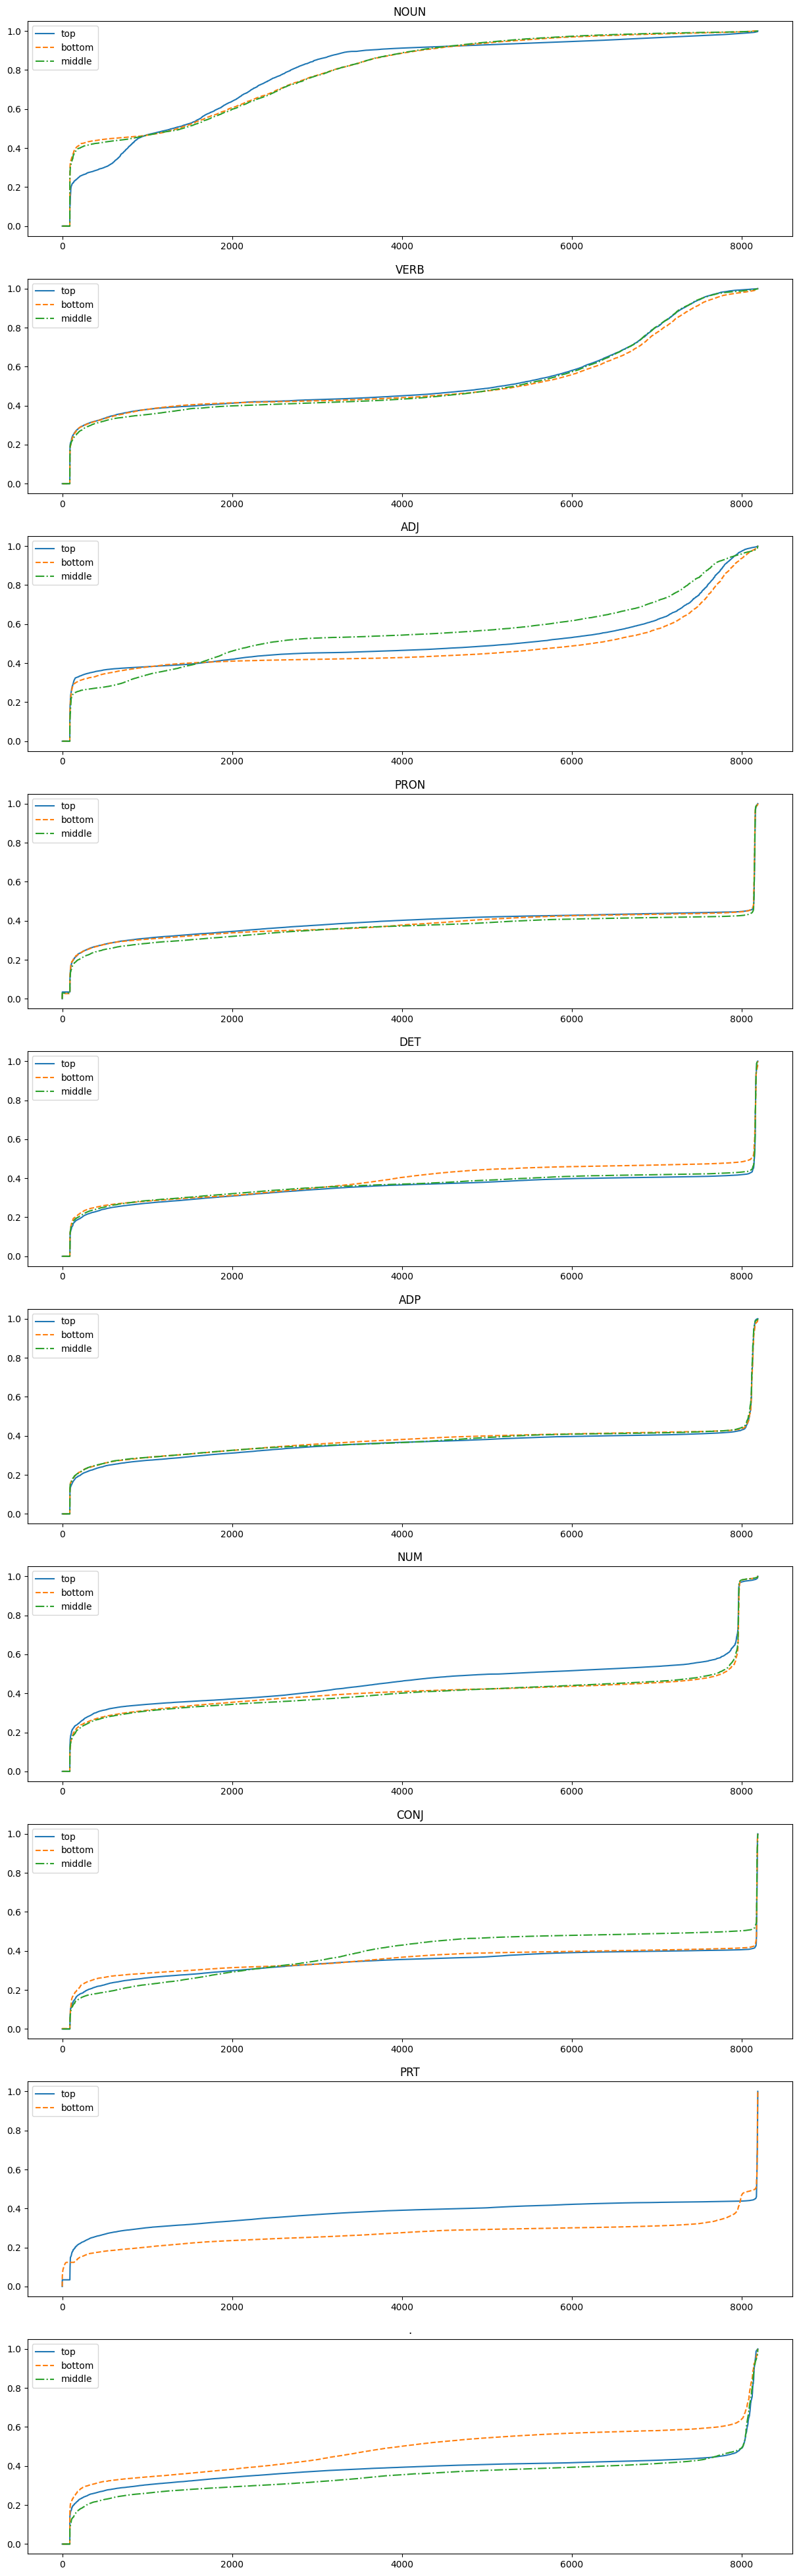

In [40]:
fig, axs = plt.subplots(len(representative_POS_tokens), 1, figsize=(15, 50))

num_from_each = 1

for plot_idx, (tag, (tag_idx, tag_idx_sorted)) in enumerate(representative_POS_tokens.items()):

    if num_from_each*2 >= len(tag_idx_sorted):
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted))
        ])
    else:
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted)),
            torch.randint(num_from_each, len(tag_idx_sorted)-num_from_each, (num_from_each,))
        ])

    pos_reprs = tag_idx_sorted[sample_idx]
    pos_reprs_sim_dist = pos_lookup.find_similar(pos_reprs)
    
    for i, val in enumerate(pos_reprs_sim_dist):

        # For the first num_from_each (top) make like solid, for the next num_from_each (bottom) make like dashed, for the rest dotted
        line_style = "-" if i < num_from_each else "--" if i < num_from_each*2 else "-."
        label = "top" if i < num_from_each else "bottom" if i < num_from_each*2 else "middle"

        similarity_vals_sorted = val.tolist()
        similarity_vals_sorted.sort()
        axs[plot_idx].plot(similarity_vals_sorted, linestyle=line_style, label=label)

    axs[plot_idx].set_title(tag)
    axs.flat[plot_idx].legend()

plt.legend()
plt.show()


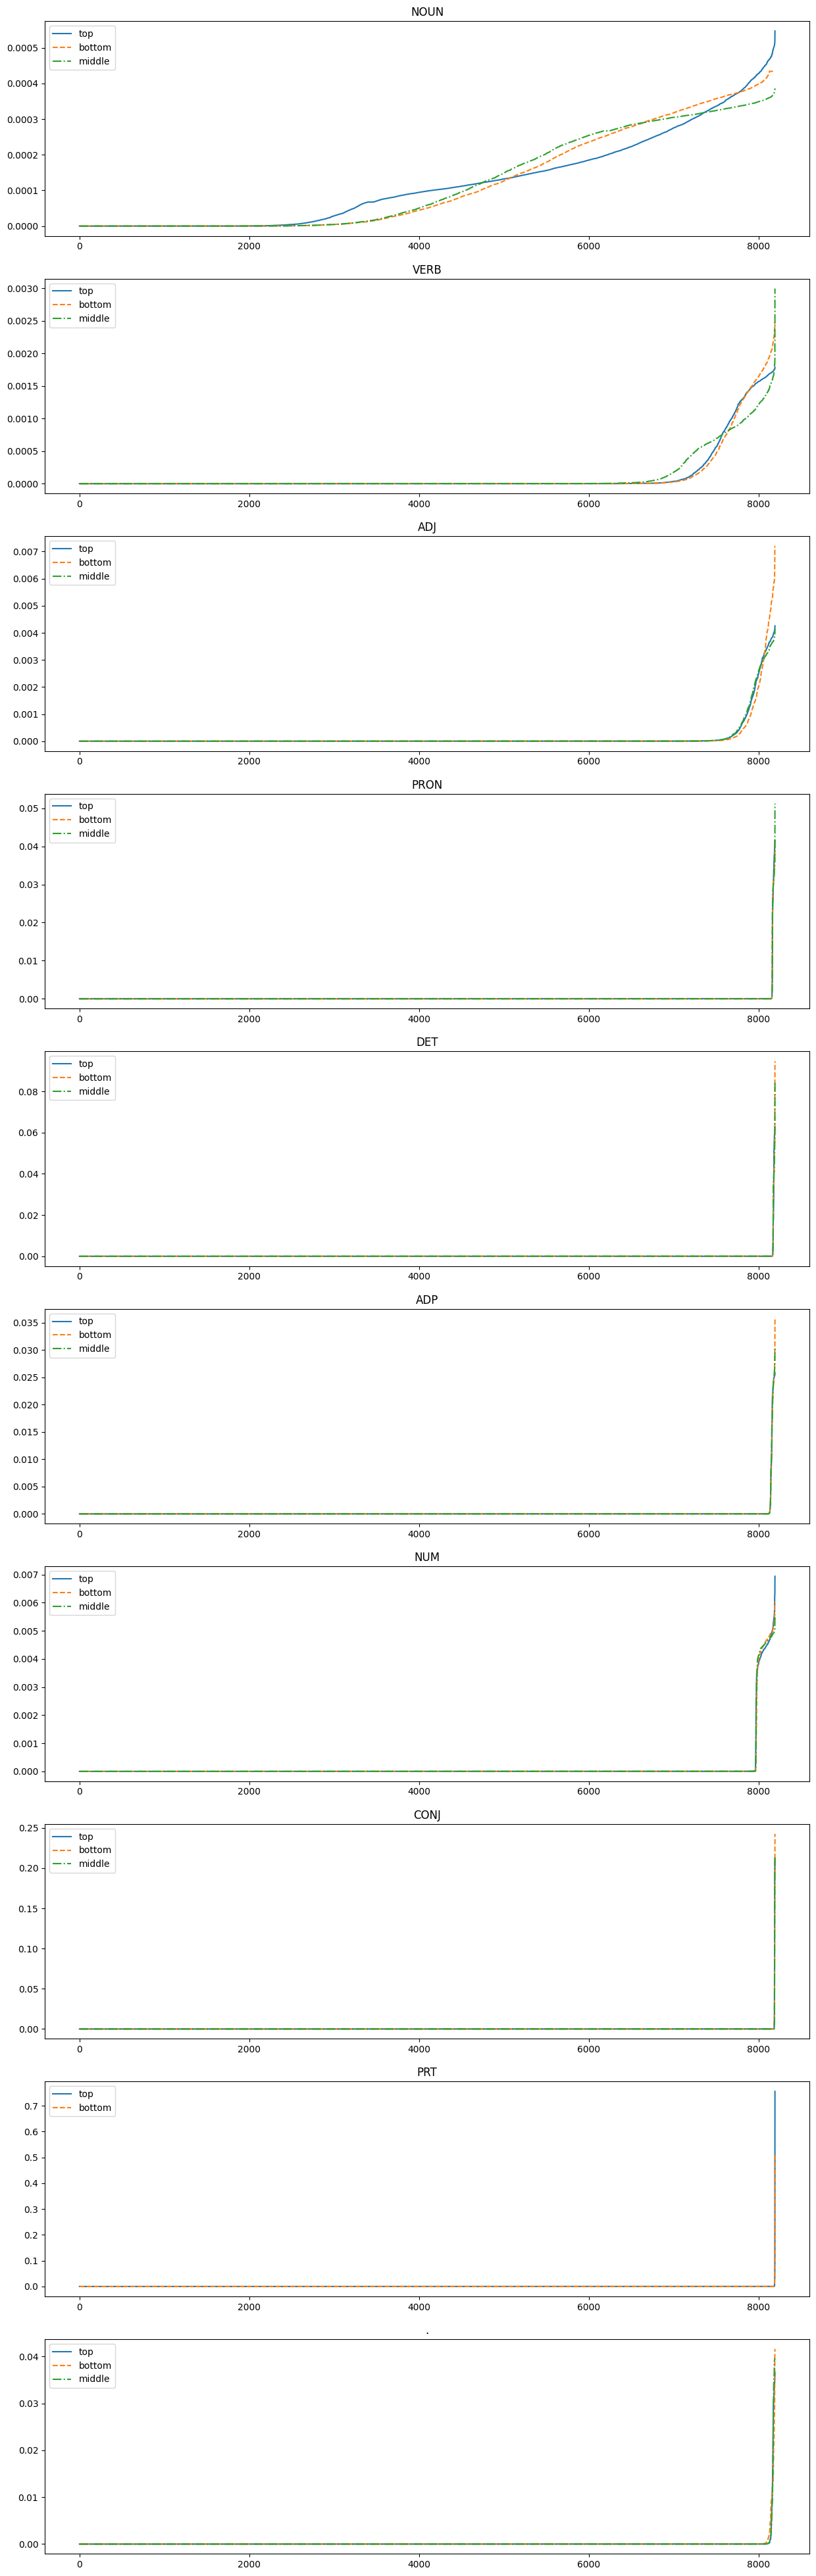

In [41]:
temp_parameter = 0.05

fig, axs = plt.subplots(len(representative_POS_tokens), 1, figsize=(15, 50))

num_from_each = 1

for plot_idx, (tag, (tag_idx, tag_idx_sorted)) in enumerate(representative_POS_tokens.items()):

    if num_from_each*2 >= len(tag_idx_sorted):
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted))
        ])
    else:
        sample_idx = torch.cat([
            torch.arange(0, num_from_each),
            torch.arange(len(tag_idx_sorted)-num_from_each, len(tag_idx_sorted)),
            torch.randint(num_from_each, len(tag_idx_sorted)-num_from_each, (num_from_each,))
        ])

    pos_reprs = tag_idx_sorted[sample_idx]
    pos_reprs_sim_dist = pos_lookup.find_similar(pos_reprs)

    # apply the temperature parameter
    pos_reprs_sim_dist = torch.exp(pos_reprs_sim_dist / temp_parameter)
    pos_reprs_sim_dist = pos_reprs_sim_dist / pos_reprs_sim_dist.sum(dim=1).unsqueeze(1)
    
    for i, val in enumerate(pos_reprs_sim_dist):

        # For the first num_from_each (top) make like solid, for the next num_from_each (bottom) make like dashed, for the rest dotted
        line_style = "-" if i < num_from_each else "--" if i < num_from_each*2 else "-."
        label = "top" if i < num_from_each else "bottom" if i < num_from_each*2 else "middle"

        similarity_vals_sorted = val.tolist()
        similarity_vals_sorted.sort()
        axs[plot_idx].plot(similarity_vals_sorted, linestyle=line_style, label=label)

    axs[plot_idx].set_title(tag)
    axs.flat[plot_idx].legend()

plt.legend()
plt.show()
